# Introduction and overview

In this course, we will build on the techniques learnt in numerical analysis in CMIII and make some of the notions there more rigorous. 

In addition to thinking about discretising in time (ODEs) we will also look at discretising differential equations in space (PDEs), and the interplay between them.

We'll start by recapitulating some of the terminology and results from CMIII, in particular stability and consistency of numerical methods for ODEs.

Some of this material is taken from [Jed Brown's](https://jedbrown.org) numerical computation course https://github.com/cucs-numcomp/numcomp-class/, licensed under BSD 2-clause.

This is a [Jupyter](https://jupyter.org) notebook, which you can execute. I recommend using something like the following:

```shell
$ python3 -m venv scicomp
$ . scicomp/bin/activate # for bash shells, other activation scripts are available
$ pip install matplotlib jupyter ipython numpy scipy
```

A readable textbook that covers this material (with more rigour than in this course, but still easy to follow) is Arieh Iserles' [*A first course in the numerical analysis of differential equations*](http://www.damtp.cam.ac.uk/user/ai/Arieh_Iserles/Textbook.html).

Our treatment will be somewhat more computational.

## Discretising an ODE

### Method of lines

When we eventually encounter spatial derivatives, along with time derivatives, we will first discretise in space, obtaining a system of ODEs and then in time. This is known as the _method of lines_. For now, we will just assume that we have already discretised in space to obtain the ODE system

$$
 \dot u = f(t, u), t \ge t_0, u(t_0) = u_0
$$

where $f : [t_0, \infty) \times \mathbb{R}^d \to \mathbb{R}^d$, $u \in \mathbb{R}^d$ and we require that $f$ is sufficiently "nice".

We will at the very least, require that $f$ is Lipschitz:

$$
\| f(t, x) - f(t, y) \| \le \lambda \| x - y \| \text{ for all } x, y \in \mathbb{R}^d, t \ge t_0,
$$

where $\lambda > 0$ is the _Lipschitz constant_. Informally, this says that we can bound the difference in the output of $f$ for two values by the difference of the values.

Sometimes we will want $f$ to be analytic (so that we can perform Taylor expansions).

This is a _first order_ ODE, since there is only one time derivative.

#### Uniqueness

If the Lipschitz condition is satisfied, one can prove that the ODE system has a unique solution.

We will call $u^*(t)$ a _solution_ to $\dot u = f(t, u)$, if, for all $t$

$$
\dot u^*(t) = f(t, u^*(t)).
$$

We note, and are not the first, that this solution usually contains a free parameter, so that for uniqueness we need to specify an _initial value_ $u(0) = u_0$. Such problems are therefore termed _initial value problems_ or IVPs.

## Discretising the $\dot u$ term

### Explicit Euler

We can formally write down the solution to our ODE problem by integrating the RHS:

$$
u(t) = u(t_0) + \int_{t_0}^t f(\tau, u(\tau)) \text{d}\tau.
$$

We can _approximate_ the integral using linear interpolation by making the approximation $f(t, u(t)) \approx f(t_0, u(t_0))$ for $t \in [t_0, t_0 + h]$ with $h > 0$ sufficiently small.

We then obtain

$$
u(t_0 + h) \approx u(t_0) + (t_0  + h - t_0)f(t_0, u(t_0))
$$

writing $u_n$ as the numerical estimate of the solution at $u(t_n)$ we obtain the explicit (or forward) Euler method:

$$
u_{n+1} = u_n + h f(t_n, u_n).
$$

Let's look at how this behaves for a sample problem (this problem is *stiff*, a property we will return to later)

$$
\dot u = -k(u - \cos{t})
$$

For an initial value $u(0) = u_0$, this problem has exact solution

$$
u(t) = \frac{k}{1+k^2}(\sin{t} + k \cos{t}) + \left(u_0 - \frac{k^2}{1+k^2}\right) \exp{(-kt)}.
$$

(hint: use an [integrating factor](https://en.wikipedia.org/wiki/Integrating_factor) and integrate by parts twice to compute the resulting integral). Note that most real problems will not have such easy to compute solutions.

Let's go ahead and integrate this equation numerically

<IPython.core.display.Javascript object>


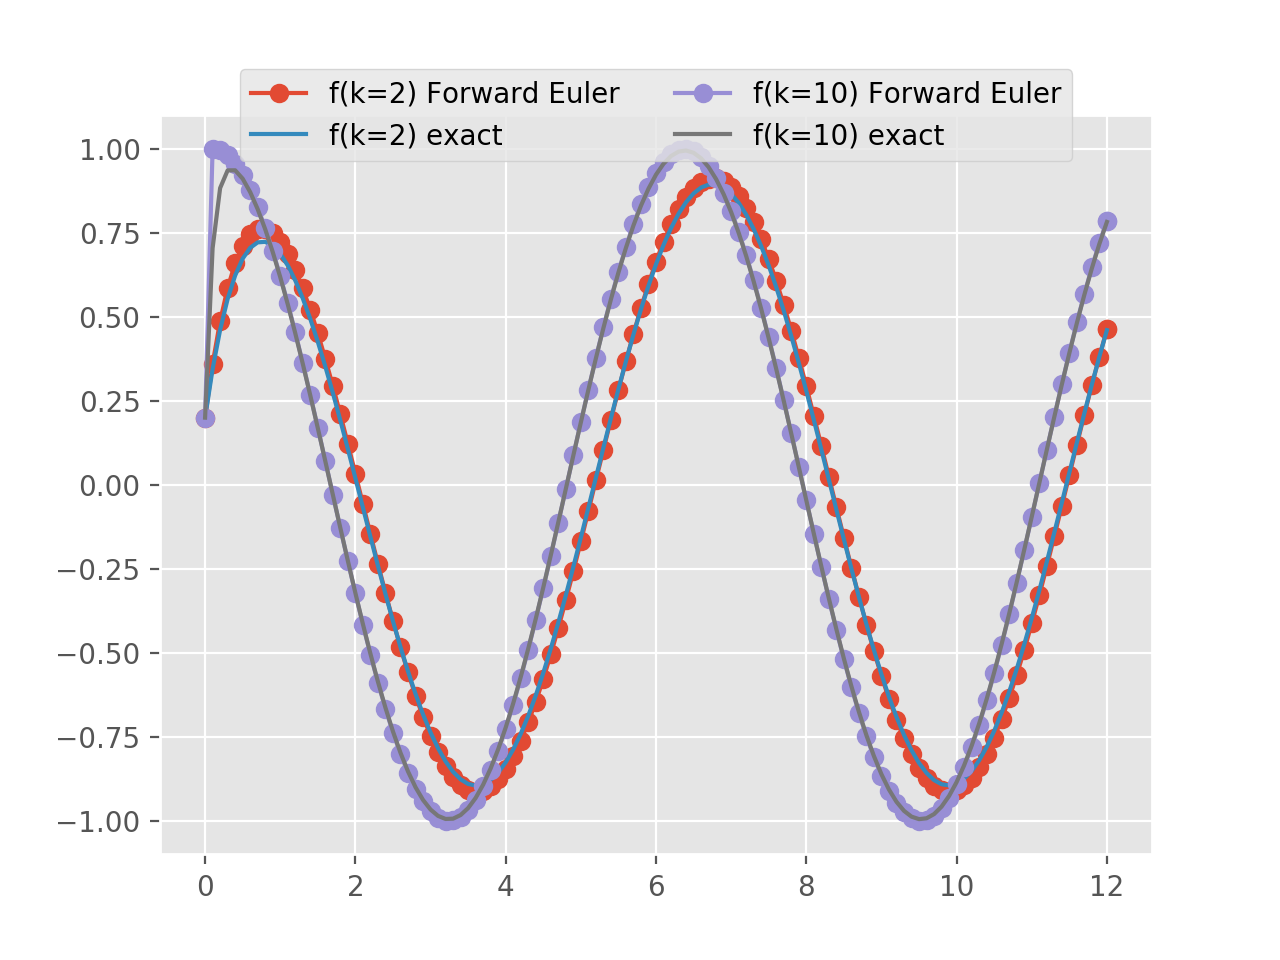

In [141]:
%matplotlib notebook
import numpy
from matplotlib import pyplot
pyplot.style.use("ggplot")

class f(object):
    def __init__(self, k):
        self.k = k
    
    def __call__(self, t, u):
        return -self.k * (u - numpy.cos(t))
    
    def __str__(self):
        return "f(k={})".format(self.k)

    def exact(self, t, u_0):
        k = self.k
        k2p1 = k/(1 + k**2)
        return (u_0 - k*k2p1)*numpy.exp(-k*t) + k2p1 * (numpy.sin(t) + k*numpy.cos(t))
    
def ode_euler(f, u_0, h=0.1, T=1):
    u = numpy.array(u_0)
    t = 0
    thist = [t]
    uhist = [u_0]
    if isinstance(f, numpy.ndarray):
        f_ = f
        # Hack for linear problems
        f = lambda t_, u_: f_ @ u_
    while t < T:
        h = min(h, T - t)
        u = u + h * f(t, u)
        t += h
        thist.append(t)
        uhist.append(u.copy())
    return numpy.asarray(thist), numpy.asarray(uhist)

u_0 = numpy.array(0.2)

pyplot.figure()

for k in [2, 10]:
    rhs = f(k)
    thist, uhist = ode_euler(rhs, u_0, h=.1, T=12)
    pyplot.plot(thist, uhist, "o", linestyle="solid", label=str(rhs)+' Forward Euler')
    pyplot.plot(thist, rhs.exact(thist, u_0), label=str(rhs)+' exact')
pyplot.legend(bbox_to_anchor=(0.5, 1), loc='center', ncol=2);

This looks pretty good in the eyeball norm.

#### Questions

1. What happens when you increase $k$ further?
2. What about if you try and increase $h$?

## Convergence of a method

A timestepping method is _convergent_ if, as we take the timestep $h \to 0$, the numerical solution tends to the exact solution. Formally, we require for a time interval $[t_0, t_0 + t^*]$ that

$$
\lim_{h \to 0^+} \max_{n} \| u_{n, h} - u(t_n) \| = 0 \text{ for all } t^* > 0,
$$
where the maximum is taken over all timesteps, $h$ denotes the step size, and $u(t_n)$ denotes the exact solution at time $t_n$.


### Is explicit Euler convergent?

Let's check. Write $e_{n, h} := u_{n, h} - u(t_n)$ for the numerical error. Write $t_{n+1} = t_n + h$ and Taylor expand $u$ around $t_n$:

$$
u(t_{n+1}) = u(t_n) + h \dot u(t_n) + \mathcal{O}(h^2).
$$

Now substitute in the definition of $\dot u$ to obtain

$$
u(t_{n+1}) = u(t_n) + h f(t, u(t_n)) + \mathcal{O}(h^2)
$$

Subtract this from the numerical $u_{n+1}$ obtained from the Euler formula to obtain

$$
e_{n+1, h} = e_{n, h} + h[f(t, \underbrace{u(t_n) + e_{n, h}}_{u_n}) - f(t, u(t_n))] + \mathcal{O}(h^2)
$$

We're interested in bounding the size of this error, so let's take norms of both sides

$$
\|e_{n+1, h}\| = \|e_{n, h} + h[f(t, u(t_n) + e_{n, h}) - f(t, u(t_n))] + \mathcal{O}(h^2)\|
$$

Now use the triangle inequality

$$
\|a + b\| \le \|a\| + \|b\|
$$

to split the term on the right hand side, and use the Lipschitz condition

$$
\begin{align}
\|e_{n+1, h}\| &\le \|e_{n, h}\| + h\|[f(t, u(t_n) + e_{n, h}) - f(t, u(t_n))]\| + \|\mathcal{O}(h^2)\|\\
&\le (1 + h\lambda)\|e_{n,h}\| + \mathcal{O}(h^2) = (1 + h\lambda)\|e_{n,h}\| + c h^2
\end{align}
$$

By induction on $n$

$$
\|e_{n, h}\| \le \frac{c}{\lambda} h [(1 + h\lambda)^n - 1], n = 0, 1, \dots
$$

Finally we have $(1 + h\lambda) < e^{h\lambda}$ (hint: taylor expand exponential and note that both $h$ and $\lambda$ are positive) and so $(1 + h\lambda)^n < e^{nh\lambda}$. Since $n$ indexes the time interval, $\max_n = \lfloor t^* / h \rfloor$ and so $e^{nh\lambda} < e^{\lfloor t^*/h \rfloor h \lambda} \le e^{t^*\lambda}$. Hence

$$
\|e_{n, h}\| \le \frac{c}{\lambda} h (e^{t^* \lambda} -1),
$$

which converges to zero as $h \to 0$.

#### Observations

It is tempting to use this to provide an upper bound on the error of the method, however, the bound is not at all sharp (typically overestimating the error by many orders of magnitude).

#### Exercises

1. Prove the relationship $\|e_{n, h}\| \le \frac{c}{\lambda} h [(1 + h\lambda)^n - 1]$ by doing the induction on $n$. Hint: use $n = 0$ for a base case noting that $e_{0, h} = 0$.

2. For the scalar equation $\dot u = -100 u, u(0) = 1$, compute the bound on the error given by our convergence proof for $t^* = 1$. Hint: since $f$ is just linear scaling, $\lambda = 100$ and we can take $c = \lambda^2$. The exact solution is $e^{-100t}$.

3. For the same equation, derive an exact expression for the error. Hint: the value computed by forward Euler after $n$ timesteps can be computed in closed form for this case by repeatedly substituting into the definition of a single timestep. Compare the the error obtained from this expression from the bound in question 2 for various values of $h$.

### The order of a method

Given some timestepping method

$$
y_{n+1} = \mathcal{Y}_n(f, h, y_0, \dots, y_n)
$$

we say it is of *order $p$* if

$$
y(t_{n+1}) - \mathcal{Y}_n(f, h, y_0, \dots, y_n) = \mathcal{O}(h^{p+1}).
$$

That is, for every timestep, we accumulate $\mathcal{O}(h^{p+1})$ error. Since we require $\mathcal{O}(h^{-1})$ timesteps, the global error will be $\mathcal{O}(h^p)$.

Note, this requires some further conditions (the method must at least be convergent), which we will come to.

### Implicit Euler

Rather than evaluating all the right hand side terms in our time discretisation *explicitly*, using already known values of $u$ at the beginning of the timestep, we can also evaluate them _implicitly_ using values at the end of the timestep. In that case, we end up with the discrete problem

$$
u(t + h) - h f(t + h, u(t + h)) = u(t).
$$

This is called _implicit_ (or backward) Euler. In the general case where $f$ is nonlinear, we must solve a nonlinear equation at this point. Let's skip over that for now and only consider the linear problem where we can write

$$
f(t, u) = A(t)u
$$

for some matrix $A(t)$ which may or may not depend on $t$.
Rearranging, we obtain

$$
(I - h A)u(t + h) = u(t)
$$

and so a single step now requires us to invert the matrix $(I - h A)$. This may be _significantly_ more expensive than just evaluating the right hand side (a matrix-vector product). So what does this buy us?

#### Aside: exact solution of linear problems

The solution to the problem
$$
\dot u = A u
$$
can be written using the [matrix exponential](https://en.wikipedia.org/wiki/Matrix_exponential) as
$$
u(t) = \exp{(A t)}u(0)
$$
where the exponential is formally defined using the Taylor series
$$
\exp{A} = \sum_{n=0}^{\infty} \frac{A^{n}}{n!},
$$
and there are many (both good and bad) [ways to compute it](https://doi.org/10.1137/S00361445024180).

If we can efficiently evaluate the matrix exponential, then we can directly compute the solution to our linear ODE at any time $t$.

### Back to Euler integration

Let's now look at the behaviour of explict and implicit Euler on a test problem with purely oscillatory solutions. Choosing

$$
A = \begin{bmatrix} 0 & 1\\ -1 & 0 \end{bmatrix}
$$
and
$$
u_0 = \begin{bmatrix} 0.75 \\ 0 \end{bmatrix}
$$
we expect
$$
u(t) = \begin{bmatrix} 0.75 \cos t\\-0.75 \sin t\end{bmatrix}.
$$

Rather than laboriously working this out each time, we can compute an "exact" solution by explicitly computing the matrix exponential. [scipy](https://scipy.org) provides a builtin function to do this, `scipy.linalg.expm`.

##### Question

If scipy didn't provide this function, can you think of a fast way of computing matrix exponentials if the matrix $A$ is diagonalisable? That is, we can write

$$
A = X \Lambda X^{-1}
$$

with

$$
\Lambda = \operatorname{diag}\lambda.
$$

Hint, substitute the expansion into the power series and note that $X X^{-1} = \mathbb{1}$, and that exponentiation of a diagonal matrix commutes. That is, if $\Lambda = \operatorname{diag}\lambda$, then $e^\Lambda = \operatorname{diag}e^{\lambda}$

<IPython.core.display.Javascript object>


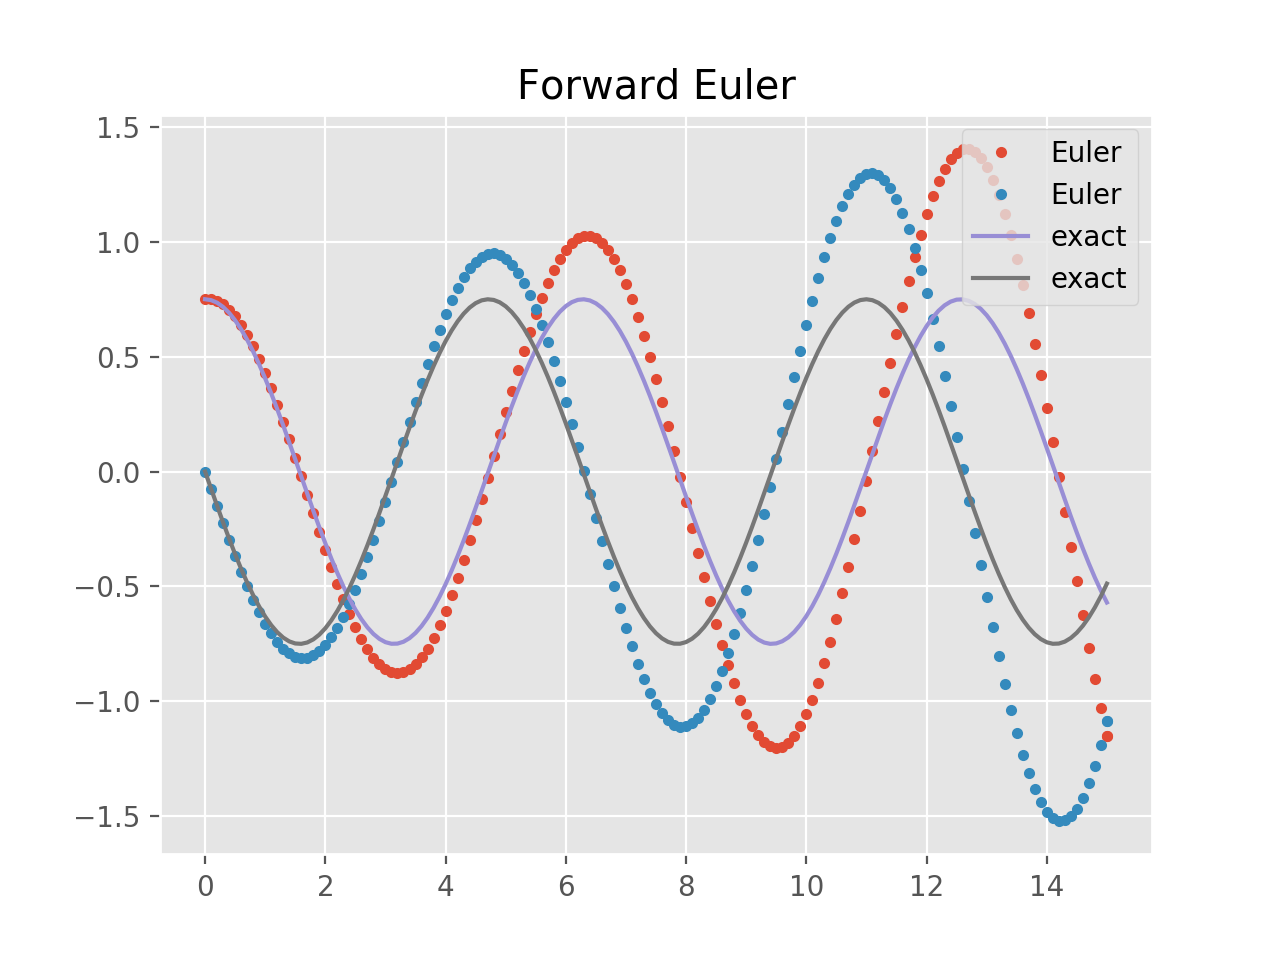

In [142]:
from scipy.linalg import expm

class linear(object):
    def __init__(self, A):
        self.A = A.copy()
    
    def __call__(self, t, u):
        return self.A @ u
    
    def exact(self, t, u_0):
        t = numpy.array(t, ndmin=1)
        return [numpy.real_if_close(expm(self.A*s) @ u_0) for s in t]

test = linear(numpy.array([[0, 1],
                           [-1, 0]]))
u_0 = numpy.array([.75, 0])
thist, uhist = ode_euler(test.A, u_0, h=.1, T=15)
pyplot.figure()
pyplot.plot(thist, uhist, '.', label='Euler')
pyplot.plot(thist, test.exact(thist, u_0), label='exact')
pyplot.legend(loc='upper right')
pyplot.title('Forward Euler');

Now let's look at backward Euler.

In [143]:
def ode_beuler(A, u_0, h=0.1, T=1):
    u = numpy.array(u_0)
    t = 0
    thist = [t]
    uhist = [u_0]
    while t < T:
        h = min(h, T - t)
        # u <- (I - h A)^{-1} u
        u = numpy.linalg.solve(numpy.eye(len(A)) - h*A, u)
        t += h
        thist.append(t)
        uhist.append(u.copy())
    return numpy.asarray(thist), numpy.asarray(uhist)

<IPython.core.display.Javascript object>


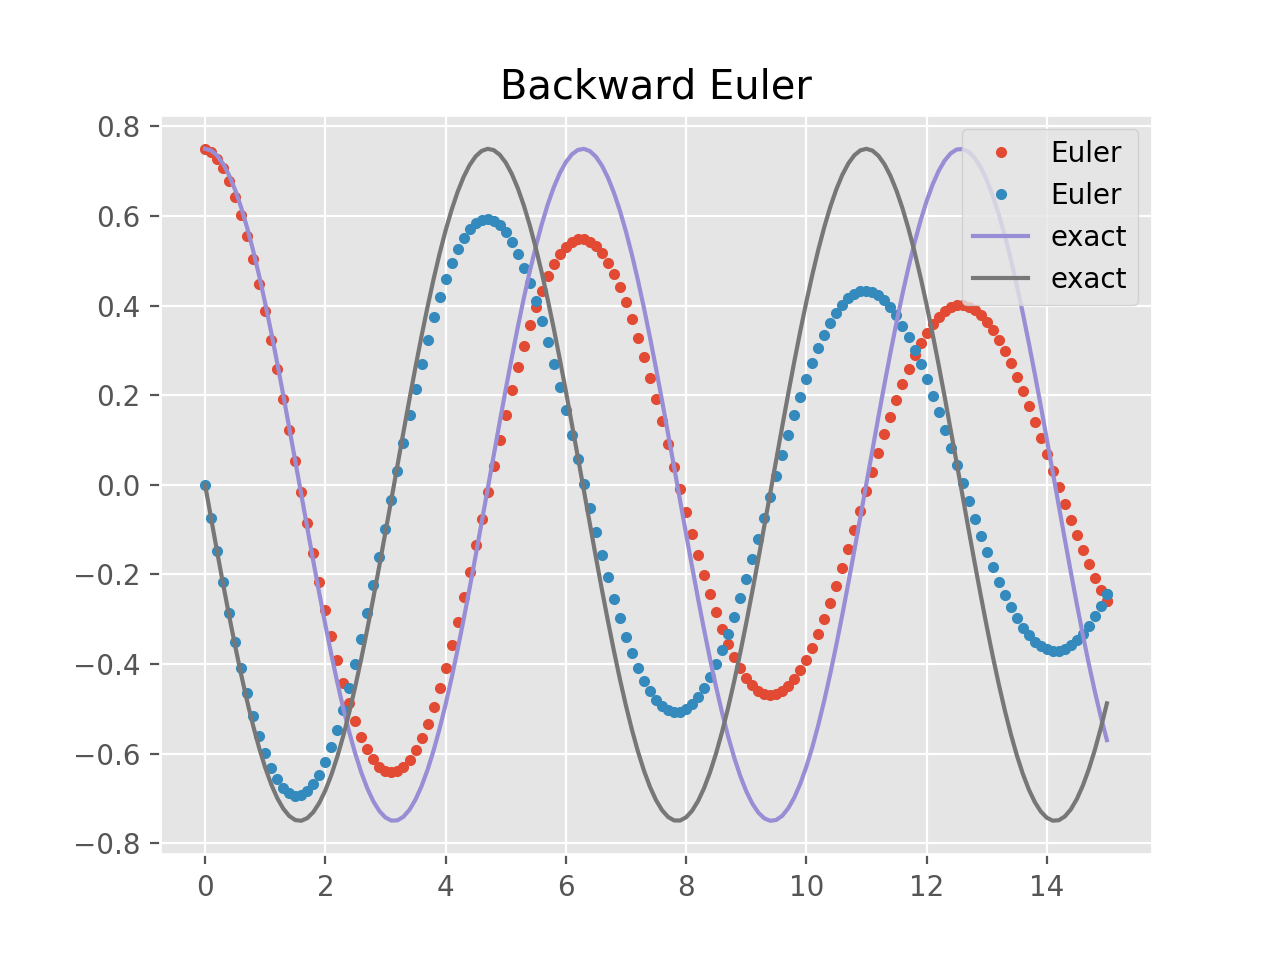

In [144]:
test = linear(numpy.array([[0, 1],
                           [-1, 0]]))
u_0 = numpy.array([.75, 0])
thist, uhist = ode_beuler(test.A, u_0, h=.1, T=15)
pyplot.figure()
pyplot.plot(thist, uhist, '.', label='Euler')
pyplot.plot(thist, test.exact(thist, u_0), label='exact')
pyplot.legend(loc='upper right')
pyplot.title('Backward Euler');

### The (implicit) midpoint method

Already for this simple problem neither forward nor backward Euler produce particularly accurate results unless we choose tiny timesteps. These are not the only choices we can make. We could instead evaluate the right hand side $f$ at the midpoint of the timestep

$$
u(t + h) = u(t) + h f\left(t + h/2, \frac{u(t) + u(t + h)}{2}\right).
$$

Which for linear problems reduces to

$$
\left(I - \frac{h}{2}\right)u(t + h) = \left(I + \frac{h}{2}\right)u(t)
$$
again requiring a solve.

### The trapezoidal rule

Another very similar scheme is obtained by making a trapezoidal approximation to the integral (rather than a linear approximation as we did for the Euler method).

$$
\begin{align}
u(t_0 + h) &= u(t_0) + \int_{t_0}^{t_0 + h} f(\tau, u(\tau)) \text{d}\tau\\
           &\approx u(t_0) + \frac{t_0 + h - t_0}{2}[f(t_0 + h, u(t_0 + h)) + f(t_0, u(t_0))]
\end{align}
$$

Resulting in the scheme:

$$
u_{n+1} = u_n + \frac{1}{2} h [f(t_n, u_n) + f(t_{n+1}, u_{n+1})]
$$

#### Questions

1. When do implicit midpoint and the trapezoidal rule differ? When are they the same?
2. Show that the trapezoidal method has order 2, i.e., that the error in a single step is $\mathcal{O}(h^3)$ (use the same mechanism as for the explicit Euler scheme, but you will need to Taylor expand one order higher)
3. Show that the trapezoidal method is convergent with convergence rate $\mathcal{O}(h^2)$.

In [145]:
def ode_midpoint(A, u_0, h=0.1, T=1):
    u = numpy.array(u_0)
    t = 0
    thist = [t]
    uhist = [u_0]
    I = numpy.eye(len(A))
    while t < T:
        h = min(h, T - t)
        # u <- (I - h/2 A)^{-1} (I + h/2 A) u
        u = numpy.linalg.solve(I - h/2*A, (I + h/2*A) @ u)
        t += h
        thist.append(t)
        uhist.append(u.copy())
    return numpy.asarray(thist), numpy.asarray(uhist)

<IPython.core.display.Javascript object>


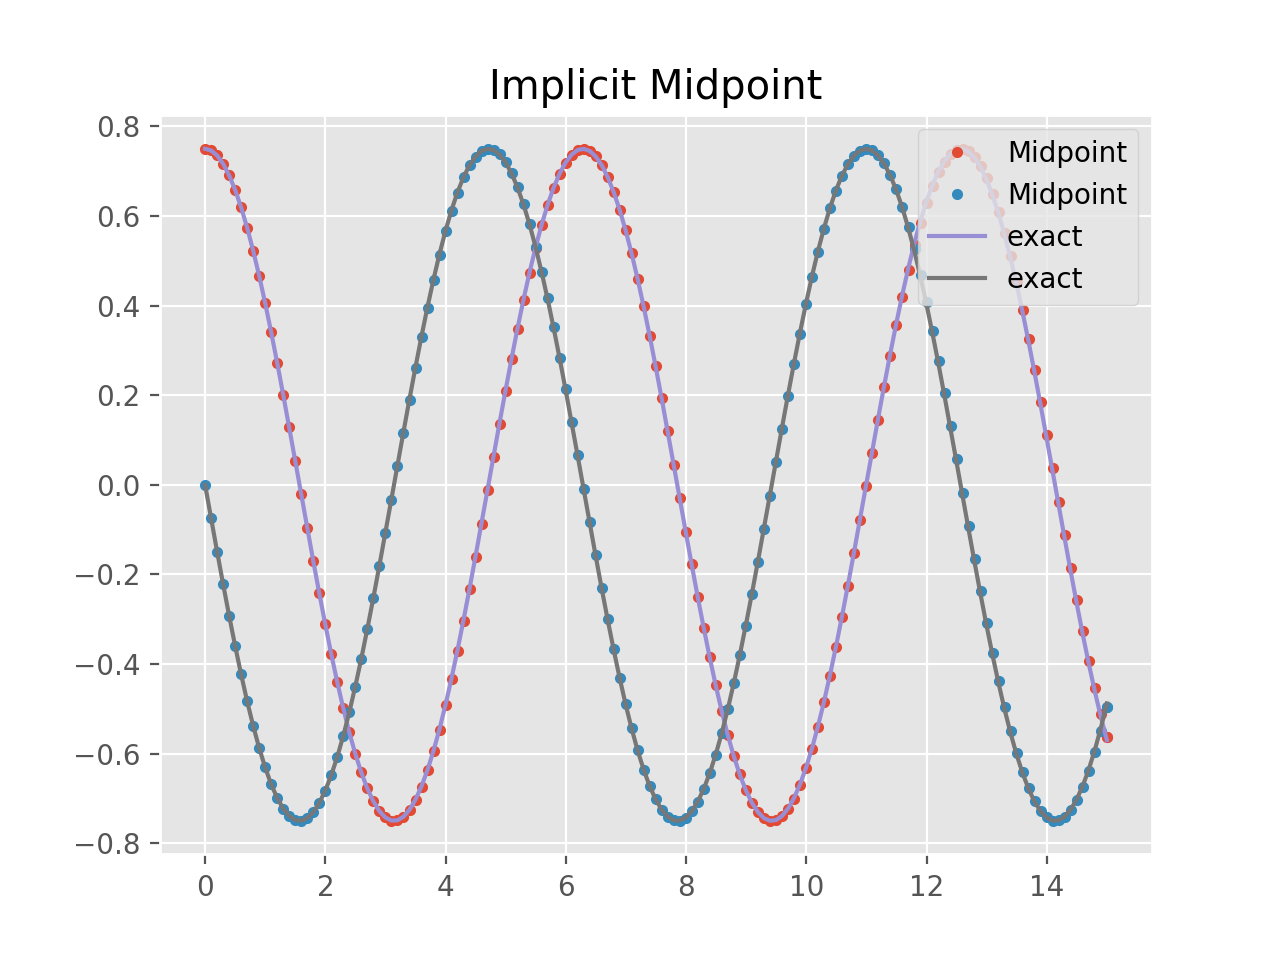

In [146]:
test = linear(numpy.array([[0, 1],
                           [-1, 0]]))
u_0 = numpy.array([.75, 0])
thist, uhist = ode_midpoint(test.A, u_0, h=.1, T=15)
pyplot.figure()
pyplot.plot(thist, uhist, '.', label='Midpoint')
pyplot.plot(thist, test.exact(thist, u_0), label='exact')
pyplot.legend(loc='upper right')
pyplot.title('Implicit Midpoint');

## Verifying the convergence of a method

An important task in scientific computing is always to verify that a numerical implementation of a scheme is correct, and as accurate as claimed. To do so, we usually compute the error as a function of step size and show that it (at least asymptotically) converges at the correct rate.

For simple test problems, we can usually construct an exact solution and explicitly measure the error. For real-world problems, this fails to be the case and we usually resort to comparing to some "ground-truth" numerical simulation (perhaps with tiny timesteps).

Construction of, and testing with, an exact solution is often called the [_method of manufactured solutions_](https://doi.org/10.1115/1.1436090).

Let's look at this for the problems we've seen so far.

<IPython.core.display.Javascript object>


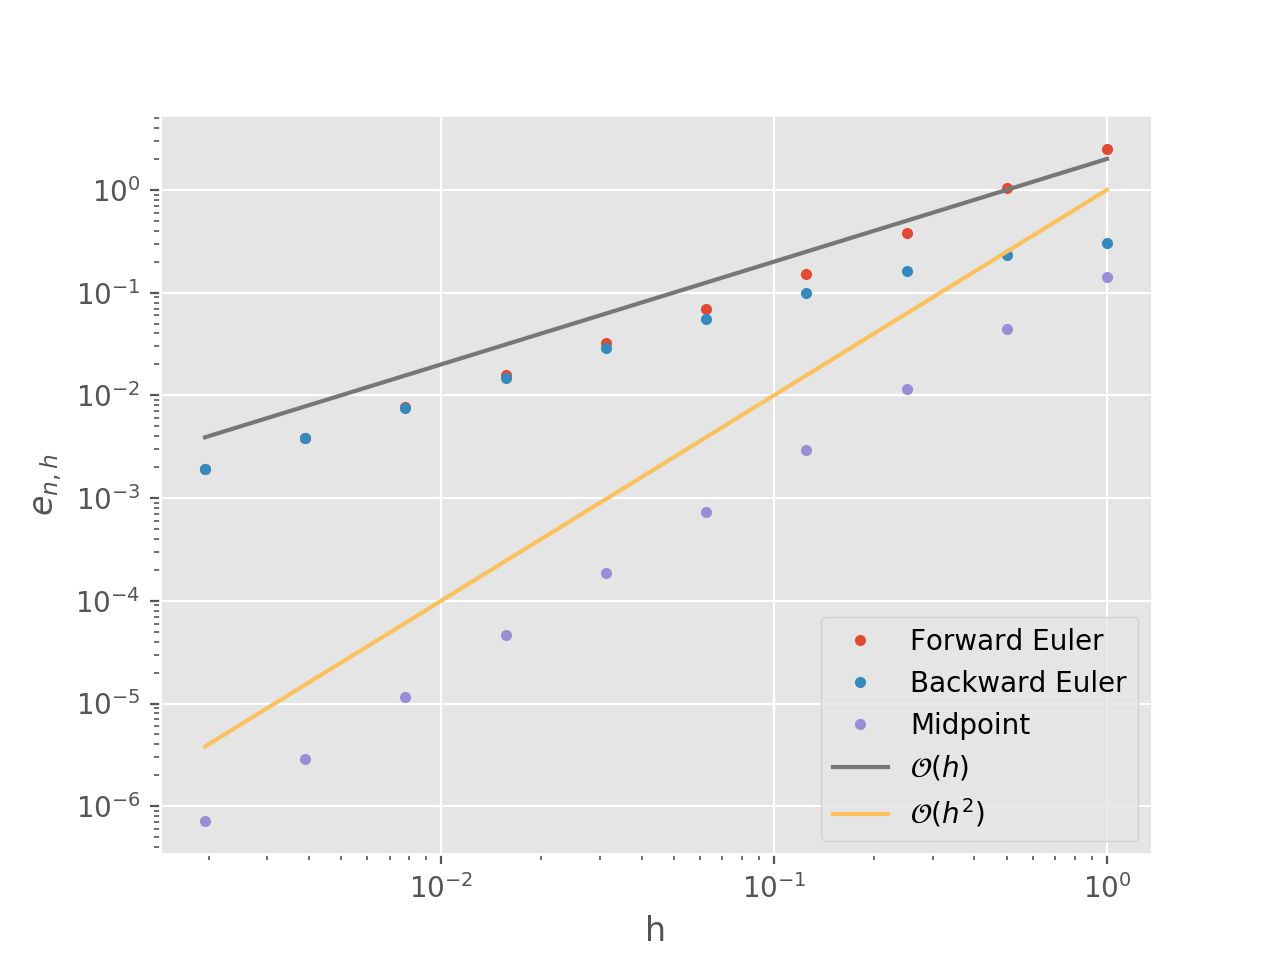

In [147]:
def mms(eqn, integrator, u_0, h=0.1, T=15):
    thist, uhist = integrator(eqn.A, u_0, h=h, T=T)
    return numpy.abs(uhist[-1] - eqn.exact(thist[-1], u_0))

eqn = linear(numpy.array([[0, 1],
                          [-1, 0]]))
u_0 = numpy.array([.75, 0])

hs = numpy.array([1/2**i for i in range(10)])
pyplot.figure()
for name, method in [("Forward Euler", ode_euler), 
                     ("Backward Euler", ode_beuler), 
                     ("Midpoint", ode_midpoint)]:
    errors = []
    for h in hs:
        error = mms(eqn, method, u_0, h=h, T=4)
        errors.append(error[0, 0])
    pyplot.loglog(hs, errors, ".", label=name)
    
pyplot.loglog(hs, 2*hs, label="$\mathcal{O}(h)$")
pyplot.loglog(hs, hs**2, label="$\mathcal{O}(h^2)$")
pyplot.legend()
pyplot.xlabel("h")
pyplot.ylabel("$e_{n,h}$");

## The importance of the Lipschitz condition

If our ODE does not obey the Lipschitz condition, we can expect that it will not perform as well as the convergence analysis suggests. As an example, consider the ODE (this example is taken from Iserles' book):

$$
\dot{u} = \left(u - \lfloor u \rfloor -\frac{3}{2}\right) \ln 3 , u(0) = 0.
$$

This has exact solution:

$$
u(t) = - \lfloor t \rfloor + \frac{1}{2}\left(1 - 3^{t - \lfloor t \rfloor}\right), t \ge 0.
$$

This equation fails the Lipschitz condition (hint: consider two points $x = m + \epsilon$ and $z = m - \epsilon$, $m \ge 1$ an integer and $\epsilon \in \left(0, \frac{1}{4}\right)$).

Let's look at what it does to the convergence of the methods we've tried.


In [151]:
import scipy.optimize

## We'll come back to rootfinding later!
def ode_trapezoid_nonlinear(f, u_0, h=0.1, T=1):
    u = numpy.array(u_0)
    t = 0
    thist = [t]
    uhist = [u_0]
    func = lambda un1, un: un1 - h/2*(f(0, un1) + f(0, un)) - un
    while t < T:
        h = min(h, T - t)
        # Solve u_{n+1} = u_n + h/2(f(t, u_{n+1}) + f(t, u_n))
        u = scipy.optimize.newton(func, u, args=(u, ), maxiter=200)
        t += h
        thist.append(t)
        uhist.append(u.copy())
    return numpy.asarray(thist), numpy.asarray(uhist)


def ode_beuler_nonlinear(f, u_0, h=0.1, T=1):
    u = numpy.array(u_0)
    t = 0
    thist = [t]
    uhist = [u_0]
    func = lambda un1, un: un1 - h*f(0, un1) - un
    while t < T:
        h = min(h, T - t)
        # Solve u_{n+1} = u_n + h f(t, u_{n+1}
        u = scipy.optimize.newton(func, u, args=(u, ), maxiter=100)
        t += h
        thist.append(t)
        uhist.append(u.copy())
    return numpy.asarray(thist), numpy.asarray(uhist)

In [152]:
class nonlipschitz(object):
    def __call__(self, t, u):
        return numpy.log(3) * (u - numpy.floor(u) - 3/2)
    def exact(self, t, u_0):
        return -numpy.floor(t) + 1/2 * (1 - 3**(t - numpy.floor(t)))

<IPython.core.display.Javascript object>


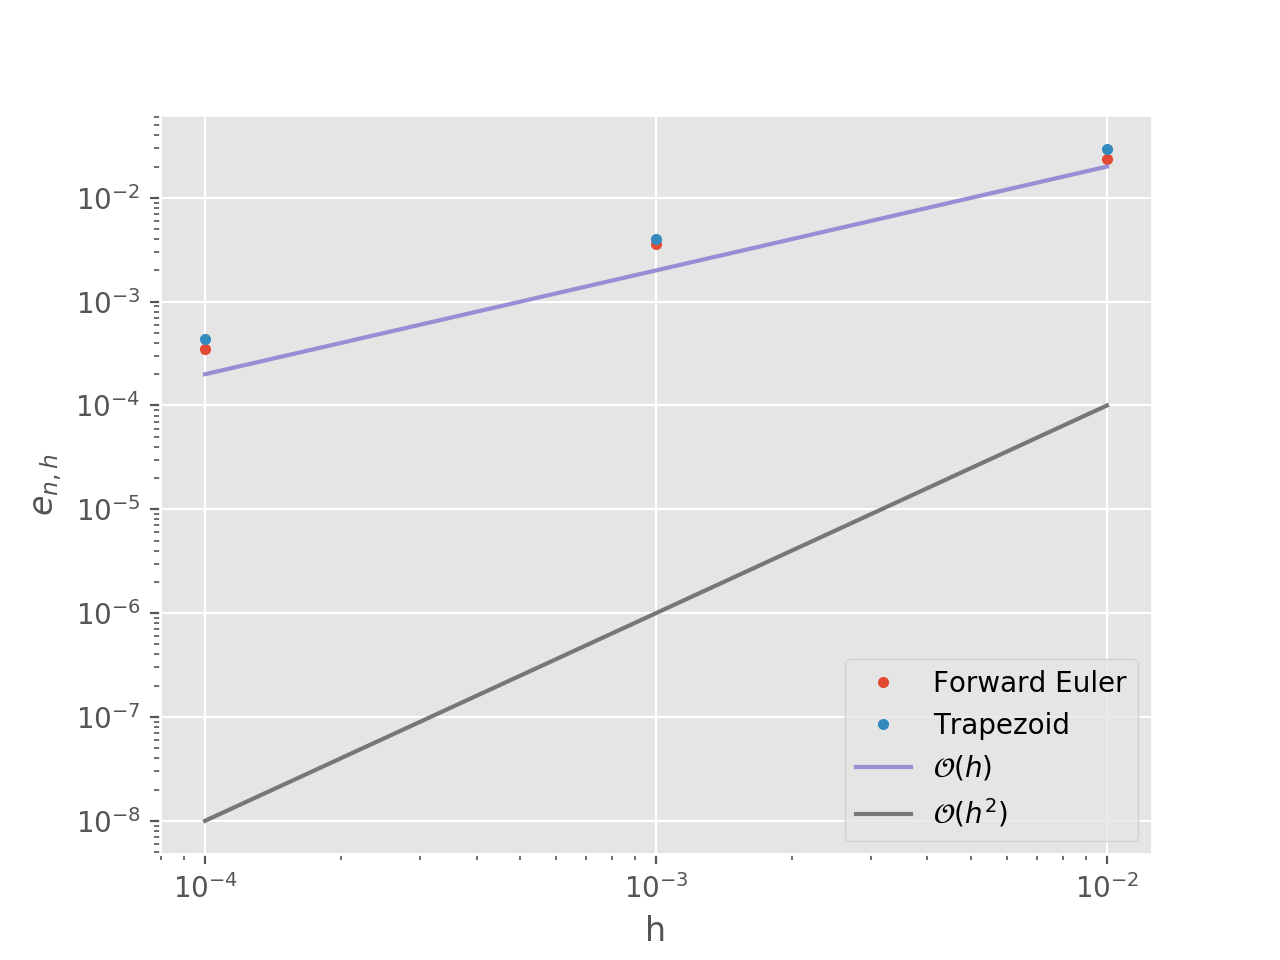

In [156]:
def mms(eqn, integrator, u_0, h=0.1, T=15):
    thist, uhist = integrator(eqn, u_0, h=h, T=T)
    return numpy.abs(uhist[-1] - eqn.exact(thist[-1], u_0))

eqn = nonlipschitz()
u_0 = numpy.array(0)

hs = numpy.array([1/10**i for i in range(2, 5)])
pyplot.figure()
for name, method in [("Forward Euler", ode_euler),
                     ("Trapezoid", ode_trapezoid_nonlinear)]:
    errors = []
    for h in hs:
        error = mms(eqn, method, u_0, h=h, T=8)
        errors.append(error)
    pyplot.loglog(hs, errors, ".", label=name)
    
pyplot.loglog(hs, 2*hs, label="$\mathcal{O}(h)$")
pyplot.loglog(hs, hs**2, label="$\mathcal{O}(h^2)$")
pyplot.legend()
pyplot.xlabel("h")
pyplot.ylabel("$e_{n,h}$");

Note how the trapezoid method, although a 2nd order method, only obtains first order convergence for this problem!

### Observations

While the physical equation is stable and remains bounded whenever $\operatorname{Re} \lambda \le 0$, the same is not true for all the methods. Explicit Euler is only stable in a disc of radius 1 centred around -1. Implicit Euler is stable _even_ in regions where the original equation is not, and tends to damp oscillations too agressively. Implicit midpoint has a stability region that exactly includes the left half plane.

### The $\theta$ method

All of these schemes are particular examples of the (implicit) $\theta$ method

$$
u(t + h) = u(t) + h f(t + \theta h, \theta u(t + h) + (1 - \theta)u(t)).
$$

With $\theta = 0$ we recover explicit Euler, $\theta = 1$ produces implicit Euler, and $\theta = 1/2$ produces implicit midpoint.

In [ ]:
def ode_theta_linear(A, u0, rhsfunc, T=1, h=0.1, theta=.5):
    u = u0.copy()
    t = 0
    hist = [(t,u0)]
    try:
        I = numpy.eye(len(A))
    except TypeError:
        I = numpy.eye(1)
    while t < T:
        h = min(h, T - t)
        rhs = (I + (1-theta)*h*A) @ u + h*rhsfunc(t+theta*h)
        u = numpy.linalg.solve(I - theta*h*A, rhs)
        t += h
        hist.append((t, u.copy()))
    return hist

In [ ]:
test = f(k=5000)

In [ ]:
theta = 0.5
u0 = numpy.array([.2])
hist = ode_theta_linear(-test.k, u0,
                        lambda t: test.k*numpy.cos(t),
                        h=.1, T=6, theta=theta)

In [ ]:
pyplot.figure()
hist = numpy.array(hist)
pyplot.plot(hist[:,0], hist[:,1], 'o', linestyle="solid", label=r"$\theta = {}$".format(theta))
tt = numpy.linspace(0, 6, 200)
pyplot.plot(tt, test.exact(tt, u0), label="Exact")
pyplot.legend();

### Observations and questions

With $\theta = 1/2$ the method converges, but oscillates about the exact solution (eventually matching it if we run for long enough).

1. What happens for $\theta < 1/2$
2. what about $\theta > 1/2$?


### Definitions

#### A-stability

A method is _A-stable_ if the stability domain

$$
S = \{z \in \mathbb{C} \colon |R(z)| \le 1\}
$$

contains the _entire_ left half plane

$$
\operatorname{Re} z \le 0.
$$

This means that we can take arbitrarily large timesteps ($\Delta t \to \infty$) without the method becoming unstable (diverging) for any problem that is physically stable.

#### L-stability

A-stability might not be enough for accurate solutions to a problem, especially if it is oscillatory (as we see above). A stronger condition is therefore sometimes used.

A method is _L-stable_ if, in addition to being A-stable we also have

$$
\lim_{z \to \infty} R(z) = 0.
$$

#### Questions

1. For what values of $\theta$ is the $\theta$ method A-stable?
2. For what values is it L-stable?

## Linear stability

To assess the stability of time integration schemes, we consider their behaviour when applied to the linear test question (called the _Dahlquist test equation_)

$$
\dot u = \lambda u
$$

where $\lambda \in \mathbb{C}$ is some complex number. When taking a step of length $h$ This equation has exact solution

$$
u(h) = u_0 \exp{(\lambda h)} = u_0 \exp{(\operatorname{Re} \lambda h)} (\cos \operatorname{Im} \lambda h) + i\sin\operatorname{Im}\lambda h).
$$

That is, there is a oscillatory component (governed by the magnitude of the imaginary part of $\lambda$) bounded by an exponential envelope.

Now consider applying a particular time discretisation scheme to the same test equation.

### Stability regions

#### Explicit Euler

$$
u(h) = R(h \lambda) u_0,
$$
where
$$
R(z) = 1 + z.
$$

Repeated application of the timestepping scheme results in

$$
u_m := u(mh) = R(z)^m u_0.
$$

$u_m$ is therefore only bounded in the set

$$
S = \{z \in \mathbb{C} \colon |R(z)| \le 1\}.
$$

#### Implicit Euler

We can perform the same calculation here to obtain

$$
R(z) = \frac{1}{1 - z}
$$

#### Implicit midpoint

This time we obtain
$$
R(z) = \frac{1 + z/2}{1 - z/2}.
$$

#### Stability plots

**Definition**: $R(z)$ is called the *stability function*, and the set $S$ is the *stability domain*.

We can graphically display the stability region by plotting $|R(z)|$ in the complex plane.

In [ ]:
def plot_stability(x, y, R, label):
    pyplot.figure()
    C = pyplot.contourf(x, y, numpy.abs(R), numpy.linspace(0, 1, 10), cmap=pyplot.cm.coolwarm)
    
    pyplot.colorbar(C, ticks=numpy.linspace(0, 1, 10))
    pyplot.contour(x, y, numpy.abs(Rz), numpy.linspace(0, 1,4), colors='k')
    pyplot.title(label)

In [ ]:
x = numpy.linspace(-3, 3)
x, y = numpy.meshgrid(x, x)
z = x + 1j*y

Rs = [("Forward Euler", 1 + z),
      ("Backward Euler", 1/(1 - z)),
      ("Implicit Midpoint", (1 + z/2)/(1 - z/2))]

for label, Rz in Rs:
    plot_stability(x, y, Rz, label)

### Observations

While the physical equation is stable and remains bounded whenever $\operatorname{Re} \lambda \le 0$, the same is not true for all the methods. Explicit Euler is only stable in a disc of radius 1 centred around -1. Implicit Euler is stable _even_ in regions where the original equation is not, and tends to damp oscillations too agressively. Implicit midpoint has a stability region that exactly includes the left half plane.

### The $\theta$ method

All of these schemes are particular examples of the (implicit) $\theta$ method

$$
u(t + h) = u(t) + h f(t + \theta h, \theta u(t + h) + (1 - \theta)u(t)).
$$

With $\theta = 0$ we recover explicit Euler, $\theta = 1$ produces implicit Euler, and $\theta = 1/2$ produces implicit midpoint.

In [ ]:
def ode_theta_linear(A, u0, rhsfunc, T=1, h=0.1, theta=.5):
    u = u0.copy()
    t = 0
    hist = [(t,u0)]
    try:
        I = numpy.eye(len(A))
    except TypeError:
        I = numpy.eye(1)
    while t < T:
        h = min(h, T - t)
        rhs = (I + (1-theta)*h*A) @ u + h*rhsfunc(t+theta*h)
        u = numpy.linalg.solve(I - theta*h*A, rhs)
        t += h
        hist.append((t, u.copy()))
    return hist

In [ ]:
test = f(k=5000)

In [ ]:
theta = 0.5
u0 = numpy.array([.2])
hist = ode_theta_linear(-test.k, u0,
                        lambda t: test.k*numpy.cos(t),
                        h=.1, T=6, theta=theta)

In [ ]:
pyplot.figure()
hist = numpy.array(hist)
pyplot.plot(hist[:,0], hist[:,1], 'o', linestyle="solid", label=r"$\theta = {}$".format(theta))
tt = numpy.linspace(0, 6, 200)
pyplot.plot(tt, test.exact(tt, u0), label="Exact")
pyplot.legend();